In [ ]:
import numpy as np
from scipy import stats

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

samples = [rng() for _ in range(1000)]

### Problem 1
Implement serial test and apply to a `samples`

In [ ]:
points=[(samples[i-1],samples[i]) for i in range(1, len(samples))[::2]]

x=[points[i][0] for i in range(len(points)) ]
y=[points[i][1] for i in range(len(points)) ]

k=20
f_obs=np.histogram2d(x,y,bins=[k,k])[0]

per_bin = len(points) / (k * k) #точки на ячейки
f_exp = np.full(k*k, per_bin)

stats.chisquare(f_obs.flatten(),f_exp)


Power_divergenceResult(statistic=386.40000000000003, pvalue=0.6653662117152015)

### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [ ]:
from itertools import permutations
n=1000
d=3
groups = [samples[i:i+d] for i in range(0, n - d + 1, d)]
perm_list = list(permutations(range(d)))
perm_count = {perm: 0 for perm in perm_list}

for group in groups:
    ranking = tuple(np.argsort(group))  # get permutation of indices
    perm_count[ranking] += 1

num_permutations = len(perm_list)
expected_freq = len(groups) / num_permutations

chi_square_stat = sum((count - expected_freq) ** 2/expected_freq for count in perm_count.values())

p_value = 1 - stats.chi2.cdf(chi_square_stat, df=num_permutations - 1)

print(f"Chi-square statistic: {chi_square_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The sequence is not uniformly random.")
else:
    print("The sequence is uniformly random.")


Chi-square statistic: 4.8559
P-value: 0.4337
The sequence is uniformly random.


### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

Использую метод подсчета рангов матриц 32*32. Почему-то все матрицы получаются одного ранга.

In [ ]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

samples_bad = [rng_bad() for _ in range(1000)]
samples = [rng() for _ in range(1000)]

In [ ]:
import numpy as np
import scipy.stats as stats

def binary_matrix_rank_test_uniform(num_matrices=10000, matrix_size=32):
    rank_counts = {32: 0, 31: 0, 30: 0, 29: 0}

    for _ in range(num_matrices):
        samples_bad = [rng() for _ in range(32)]
        matrix = np.array([
            [int(bit) for bit in format(int(num * (2**32)), '032b')]  # Convert each to 32-bit binary
            for num in samples_bad
        ])

        rank = np.linalg.matrix_rank(matrix)

        if rank < 29:
            rank_counts[29] += 1
        else:
            rank_counts[rank] += 1

    observed_counts = [rank_counts[32], rank_counts[31], rank_counts[30], rank_counts[29]]

    #expected probabilities for ranks 32, 31, 30, and <=29 (Marsaglia & Tsang, 2002)
    expected_probs = [0.2888, 0.5776, 0.1288, 0.0048]
    expected_counts = [prob * num_matrices for prob in expected_probs]

    chi2_stat, p_value = stats.chisquare(observed_counts, f_exp=expected_counts)

    return chi2_stat, p_value, rank_counts

chi2_stat, p_value, rank_counts = binary_matrix_rank_test_uniform()

print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Observed counts:", rank_counts)


Chi-square statistic: 24626.038781163435
P-value: 0.0
Observed counts: {32: 10000, 31: 0, 30: 0, 29: 0}


### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

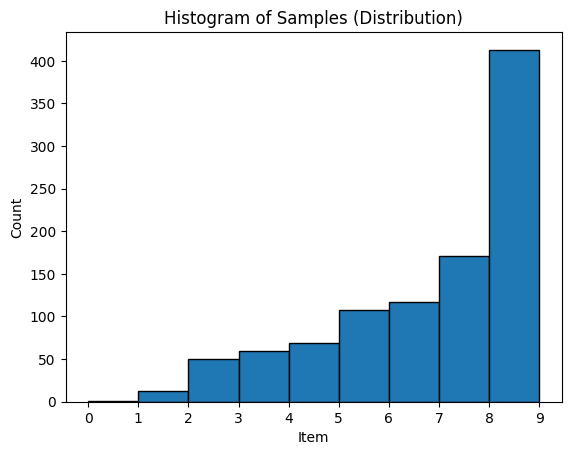

In [36]:

import matplotlib.pyplot as plt
vals=np.arange(0,10,1)
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

weights_sorted = np.sort(weights/weights.sum())
rand_sort = np.random.choice(vals, size=1000, p=weights_sorted)

plt.hist(rand_sort, vals, align='mid', edgecolor='black')
plt.xticks(vals)
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Histogram of Samples (Distribution)')
plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

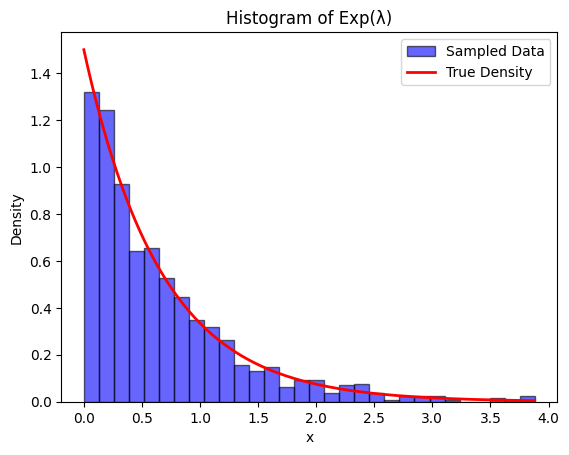

In [ ]:
import scipy.stats as stats

lambda_param = 1.5
U = np.random.rand(1000)

X = -np.log(1 - U) / lambda_param

plt.hist(X, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Sampled Data")

x = np.linspace(0, np.max(X), 1000)
y = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, y, 'r-', lw=2, label="True Density")

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram of Exp(λ)")
plt.legend()
plt.show()


### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

Normalization constant C = 1.841


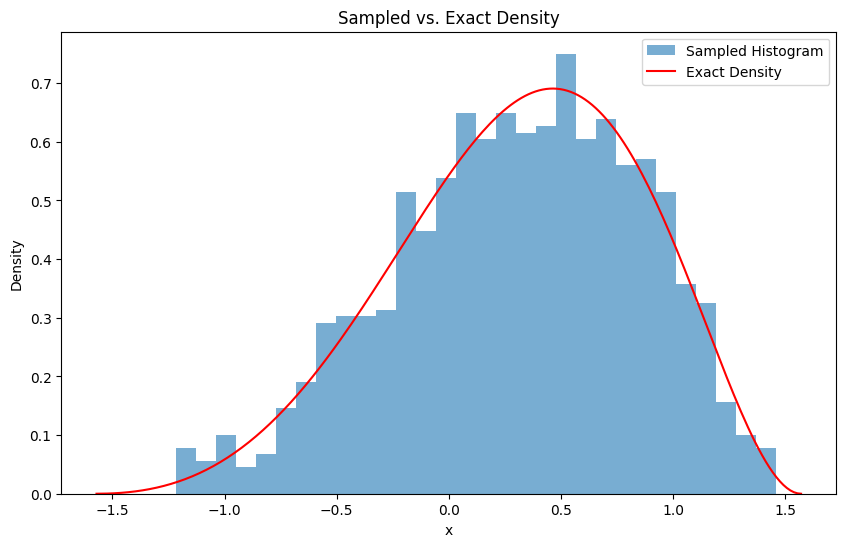

In [ ]:
from scipy.integrate import quad

def integrand(x):
    return np.exp(x) * (np.cos(x))**2

C, _ = quad(integrand, -np.pi/2, np.pi/2)
print(f"Normalization constant C = {C:.3f}")

def exact_density(x):
    return np.exp(x) * (np.cos(x))**2 / C

samples = []
num_accepted = 0

while num_accepted < 1000:
    x = np.random.uniform(-np.pi/2, np.pi/2)
    u = np.random.uniform(0, 1)
    if u <= np.exp(x) * (np.cos(x))**2:
        samples.append(x)
        num_accepted += 1


plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, label='Sampled Histogram')

x = np.linspace(-np.pi/2, np.pi/2, 200)
y = exact_density(x)
plt.plot(x, y, 'r-', label='Exact Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sampled vs. Exact Density')
plt.legend()
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

The formula is derived using barycentric coordinates $$P=(1-u-v)A+uB+vC$$ and a transformation to ensure uniform sampling. The use of $\sqrt{u}$ preserves the area ratio, making the points uniformly distributed within the triangle.

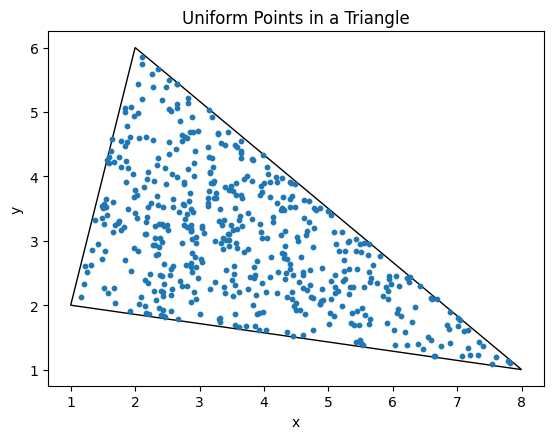

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

vertices = np.array([[1, 2], [2, 6], [8, 1]])

def uniform_triangle_sample(vertices, num_points):
    u = np.random.uniform(0, 1, num_points)
    v = np.random.uniform(0, 1, num_points)

    x = (1 - np.sqrt(u))*vertices[0, 0] + np.sqrt(u)*(1 - v)*vertices[1, 0] + np.sqrt(u)*v* vertices[2, 0]
    y = (1 - np.sqrt(u))*vertices[0, 1] + np.sqrt(u) * (1 - v)*vertices[1, 1] + np.sqrt(u)*v*vertices[2, 1]
    return np.column_stack((x, y))

points = uniform_triangle_sample(vertices, 500)

fig, ax = plt.subplots()
polygon = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
ax.add_patch(polygon)
ax.scatter(points[:, 0], points[:, 1], s=10)
ax.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniform Points in a Triangle')
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

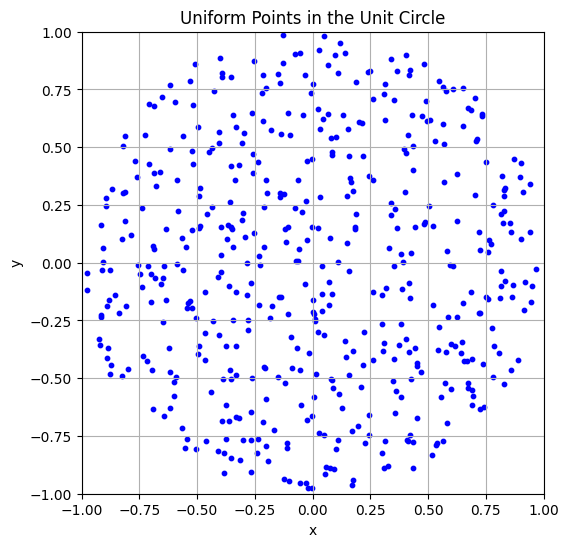

P-value: 0.940
The points are uniformly distributed


In [ ]:
def uniform_unit_circle_sample(num_points):
    u = np.random.uniform(0, 1, num_points)
    r = np.sqrt(u)  #to ensure uniform density
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

x, y = uniform_unit_circle_sample(500)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=10, color='blue')
plt.gca().set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Uniform Points in the Unit Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

def test_uniformity(x, y, num_regions=10):
    radii = np.sqrt(np.linspace(0, 1, num_regions + 1))
    observed_counts, _ = np.histogram(np.sqrt(x**2 + y**2), bins=radii)

    expected_counts = np.full(num_regions, len(x) / num_regions)

    chi2_stat, p_value = stats.chisquare(observed_counts, f_exp=expected_counts)

    return chi2_stat, p_value

p_value = test_uniformity(x, y)[1]
print(f"P-value: {p_value:.3f}")
if p_value > 0.05:
    print("The points are uniformly distributed")
else:
    print("The points are NOT uniformly distributed")

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

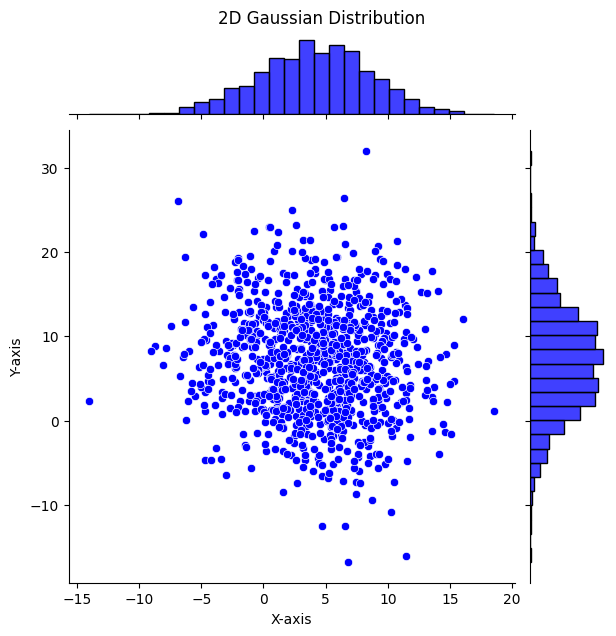

Mean coord. differences: [0.06980933 0.00213839]
Covariance coord. differences:
 [[0.29637355 1.06855597]
 [1.06855597 1.14481012]]


In [ ]:
import seaborn as sns

mu = np.array([4, 7])
sigma = np.array([[20, -4], [-4, 40]])

L = np.linalg.cholesky(sigma)

def generate_normal_samples(n):
    samples = []
    while len(samples) < n:
        U1 = np.random.uniform(-1,1)
        U2=np.random.uniform(-1,1)
        S = U1**2 + U2**2
        if 0 < S < 1:
            factor = np.sqrt(-2 *np.log(S)/S)
            samples.append(U1*factor)
            samples.append(U2*factor)
    return np.array(samples[:n])

Z = np.column_stack((generate_normal_samples(1000), generate_normal_samples(1000)))

#еransform standard normal samples to the given gaussian distribution
X = (L @ Z.T).T + mu
joint_plot = sns.jointplot(x=X[:, 0], y=X[:, 1], color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

sample_mean = np.mean(X, axis=0)
sample_cov = np.cov(X.T)

print("Mean coord. differences:", np.abs(sample_mean-mu))
print("Covariance coord. differences:\n", np.abs(sample_cov-sigma))